In [ ]:
# default_exp models.gcn

# GCN
> Implementation of Graph Convolutional Networks.

In [ ]:
#hide
from nbdev.showdoc import *
from fastcore.nb_imports import *
from fastcore.test import *

In [ ]:
#export
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

## Simple GCN Layer

The **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)), is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.

PyG implements this layer via [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv), which can be executed by passing in the node feature representation `x` and the COO graph connectivity representation `edge_index`.

In [ ]:
#export
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes, seed=12345):
        super().__init__()
        torch.manual_seed(seed)
        self.conv1 = GCNConv(num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        # Apply a final (linear) classifier.
        out = self.classifier(h)
        return out, h

Here, we first initialize all of our building blocks in `__init__` and define the computation flow of our network in `forward`.
We first define and stack **three graph convolution layers**, which corresponds to aggregating 3-hop neighborhood information around each node (all nodes up to 3 "hops" away).
In addition, the `GCNConv` layers reduce the node feature dimensionality to $2$, *i.e.*, $34 \rightarrow 4 \rightarrow 4 \rightarrow 2$. Each `GCNConv` layer is enhanced by a [tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html?highlight=tanh#torch.nn.Tanh) non-linearity.

After that, we apply a single linear transformation ([`torch.nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear)) that acts as a classifier to map our nodes to 1 out of the 4 classes/communities.

We return both the output of the final classifier as well as the final node embeddings produced by our GNN.
We proceed to initialize our final model via `GCN()`, and printing our model produces a summary of all its used sub-modules.


### Example: Embedding the Karate Club Network

In [ ]:
from recohut.datasets.bases.graph import PyGDataset
from recohut.utils.plots import GraphNetworkPlot

from tqdm import tqdm

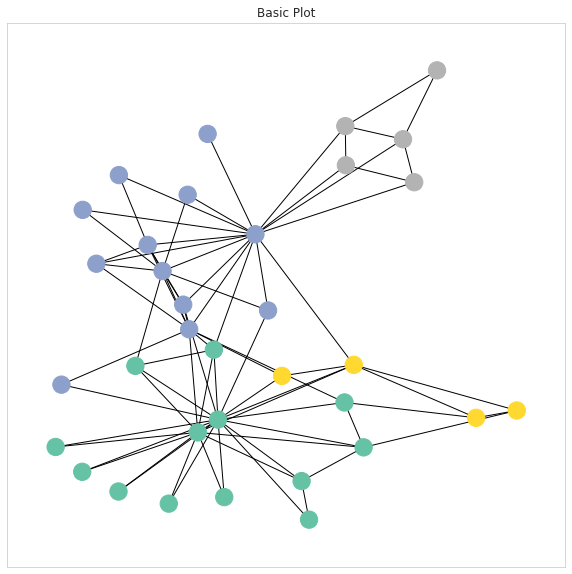

In [ ]:
karate_club = PyGDataset()
karate_club.load('KarateClub')
karate_club.plot()

Let's take a look at the node embeddings produced by our GNN.
Here, we pass in the initial node features `x` and the graph connectivity information `edge_index` to the model, and visualize its 2-dimensional embedding.

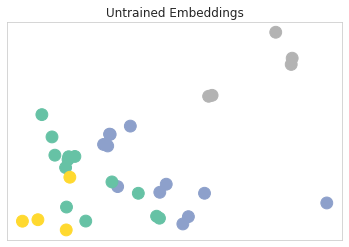

In [ ]:
model = GCN(num_features = karate_club.dataset.num_features,
            num_classes = karate_club.dataset.num_classes)

data = karate_club.dataset[0]

_, h = model(data.x, data.edge_index)

kwargs = {'figsize':(6,4), 'title':'Untrained Embeddings'}
_ = GraphNetworkPlot(h, color=data.y, **kwargs)

Remarkably, even before training the weights of our model, the model produces an embedding of nodes that closely resembles the community-structure of the graph.
Nodes of the same color (community) are already closely clustered together in the embedding space, although the weights of our model are initialized **completely at random** and we have not yet performed any training so far!
This leads to the conclusion that GNNs introduce a strong inductive bias, leading to similar embeddings for nodes that are close to each other in the input graph.

**Training on the Karate Club Network**

But can we do better? Let's look at an example on how to train our network parameters based on the knowledge of the community assignments of 4 nodes in the graph (one for each community):

Since everything in our model is differentiable and parameterized, we can add some labels, train the model and observse how the embeddings react.
Here, we make use of a semi-supervised or transductive learning procedure: We simply train against one node per class, but are allowed to make use of the complete input graph data.

Training our model is very similar to any other PyTorch model.
In addition to defining our network architecture, we define a loss critertion (here, [`CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)) and initialize a stochastic gradient optimizer (here, [`Adam`](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam)).
After that, we perform multiple rounds of optimization, where each round consists of a forward and backward pass to compute the gradients of our model parameters w.r.t. to the loss derived from the forward pass.
If you are not new to PyTorch, this scheme should appear familar to you. 
Otherwise, the PyTorch docs provide [a good introduction on how to train a neural network in PyTorch](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#define-a-loss-function-and-optimizer).

Note that our semi-supervised learning scenario is achieved by the following line:
```
loss = criterion(out[data.train_mask], data.y[data.train_mask])
```
While we compute node embeddings for all of our nodes, we **only make use of the training nodes for computing the loss**.
Here, this is implemented by filtering the output of the classifier `out` and ground-truth labels `data.y` to only contain the nodes in the `train_mask`.

Let us now start training and see how our node embeddings evolve over time (best experienced by explicitely running the code):

100%|██████████| 500/500 [00:01<00:00, 376.81it/s]


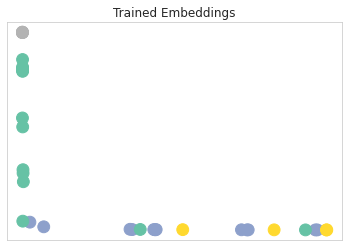

In [ ]:
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

for epoch in tqdm(range(500)):
    loss, h = train(data)

kwargs = {'figsize':(6,4), 'title':'Trained Embeddings'}
_ = GraphNetworkPlot(h, color=data.y, **kwargs)

As one can see, our 3-layer GCN model manages to linearly separating the communities and classifying most of the nodes correctly.

Furthermore, we did this all with a few lines of code, thanks to the PyTorch Geometric library which helped us out with data handling and GNN implementations.
